# Feature Importance

## Data Preparation

In [1]:
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import scikitplot
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Load Previous Trained Model

In [2]:
from tensorflow.keras.models import load_model

model = load_model('../../../2_Modeling_Phase/Saved-Models/cicids-2017-dnn.keras')

2024-04-11 16:23:51.383639: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 16:23:51.384023: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 16:23:51.386350: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 16:23:51.415523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 16:23:51.939023: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

-----
## Train and Test Datasets

In [3]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep]

In [4]:
def get_PCA_feature_names(num_of_pca_components, original_feature_names):
    if num_of_pca_components > len(original_feature_names):
        raise ValueError("Number of PCA components exceeds the number of original features.")
    return original_feature_names[:num_of_pca_components]

In [5]:
dimensions_num_for_PCA = 7
num_of_splits_for_skf = 10

In [6]:
Friday_Morning_Data = pd.read_csv('../../../0_Datasets/cicids-2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df = Friday_Morning_Data.copy()
print("Datatype of Dataframe i.e. Pandas Dataframe: ", type(df))
print("Datatype of Column i.e. Pandas Series: ", type(df.iloc[:, 1]))
df.head()

Datatype of Dataframe i.e. Pandas Dataframe:  <class 'pandas.core.frame.DataFrame'>
Datatype of Column i.e. Pandas Series:  <class 'pandas.core.series.Series'>


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [7]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [8]:
df.dtypes

destination_port                 int64
flow_duration                    int64
total_fwd_packets                int64
total_backward_packets           int64
total_length_of_fwd_packets      int64
                                ...   
idle_mean                      float64
idle_std                       float64
idle_max                         int64
idle_min                         int64
label                           object
Length: 79, dtype: object

In [9]:
df_cleaned = df.copy()
df_cleaned = clean_dataset(df_cleaned) # see methods at top of notebook
df_cleaned

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286462,443,196135,49,57,1331,105841,570,0,27.163265,108.067176,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286463,443,378424,49,59,1325,104393,570,0,27.040816,108.095051,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286464,443,161800,70,103,1427,215903,570,0,20.385714,90.746389,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286465,443,142864,50,62,1331,110185,570,0,26.620000,107.027727,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [10]:
df.columns.tolist()

['destination_port',
 'flow_duration',
 'total_fwd_packets',
 'total_backward_packets',
 'total_length_of_fwd_packets',
 'total_length_of_bwd_packets',
 'fwd_packet_length_max',
 'fwd_packet_length_min',
 'fwd_packet_length_mean',
 'fwd_packet_length_std',
 'bwd_packet_length_max',
 'bwd_packet_length_min',
 'bwd_packet_length_mean',
 'bwd_packet_length_std',
 'flow_bytes/s',
 'flow_packets/s',
 'flow_iat_mean',
 'flow_iat_std',
 'flow_iat_max',
 'flow_iat_min',
 'fwd_iat_total',
 'fwd_iat_mean',
 'fwd_iat_std',
 'fwd_iat_max',
 'fwd_iat_min',
 'bwd_iat_total',
 'bwd_iat_mean',
 'bwd_iat_std',
 'bwd_iat_max',
 'bwd_iat_min',
 'fwd_psh_flags',
 'bwd_psh_flags',
 'fwd_urg_flags',
 'bwd_urg_flags',
 'fwd_header_length',
 'bwd_header_length',
 'fwd_packets/s',
 'bwd_packets/s',
 'min_packet_length',
 'max_packet_length',
 'packet_length_mean',
 'packet_length_std',
 'packet_length_variance',
 'fin_flag_count',
 'syn_flag_count',
 'rst_flag_count',
 'psh_flag_count',
 'ack_flag_count',
 'ur

In [11]:
df_labels = df_cleaned['label']
df_labels.unique()

array(['BENIGN', 'PortScan'], dtype=object)

In [12]:
df_labels

0         BENIGN
1         BENIGN
2         BENIGN
3         BENIGN
4         BENIGN
           ...  
286462    BENIGN
286463    BENIGN
286464    BENIGN
286465    BENIGN
286466    BENIGN
Name: label, Length: 286096, dtype: object

In [13]:
df_no_labels = df_cleaned.drop('label', axis=1, inplace=False)
df_features = df_no_labels.columns.tolist()
df_no_labels

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286462,443,196135,49,57,1331,105841,570,0,27.163265,108.067176,...,31,20,0.0,0.0,0,0,0.0,0.0,0,0
286463,443,378424,49,59,1325,104393,570,0,27.040816,108.095051,...,30,20,0.0,0.0,0,0,0.0,0.0,0,0
286464,443,161800,70,103,1427,215903,570,0,20.385714,90.746389,...,47,20,0.0,0.0,0,0,0.0,0.0,0,0
286465,443,142864,50,62,1331,110185,570,0,26.620000,107.027727,...,31,20,0.0,0.0,0,0,0.0,0.0,0,0


In [14]:
df_scaled = StandardScaler().fit_transform(df_no_labels)
df_scaled = pd.DataFrame(data = df_scaled, columns = df_features)
df_scaled

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,-0.520898,-0.187809,1.921576,1.429893,1.301913,0.083183,1.143000,-0.427193,0.520360,0.726763,...,1.493893,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
1,-0.520898,-0.185393,1.921576,1.429893,1.301913,0.083183,1.143000,-0.427193,0.520360,0.726763,...,1.493893,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
2,-0.520898,-0.245528,-0.126811,-0.089163,-0.125195,-0.053141,-0.247378,-0.427193,-0.308105,-0.209924,...,-0.116102,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
3,-0.520898,-0.186116,1.921576,1.359240,1.336198,0.076910,1.143000,-0.427193,0.540263,0.729026,...,1.493893,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
4,1.784164,-0.245532,-0.126811,-0.053837,-0.125195,-0.053141,-0.247378,-0.427193,-0.308105,-0.209924,...,-0.116102,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286091,-0.493464,-0.236595,2.331253,1.889143,0.587823,2.021738,1.490594,-0.427193,0.038237,0.711439,...,1.963476,-1.133141,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
286092,-0.493464,-0.228285,2.331253,1.959797,0.584609,1.993352,1.490594,-0.427193,0.036676,0.711676,...,1.896392,-1.133141,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
286093,-0.493464,-0.238160,3.406657,3.514181,0.639251,4.179364,1.490594,-0.427193,-0.048179,0.563765,...,3.036806,-1.133141,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
286094,-0.493464,-0.239023,2.382463,2.065778,0.587823,2.106896,1.490594,-0.427193,0.031310,0.702577,...,1.963476,-1.133141,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561


In [15]:
pca = PCA(n_components=dimensions_num_for_PCA)
principal_components = pca.fit(df_no_labels).transform(df_no_labels)
principal_components

array([[-8.16580279e+06, -1.19915322e+06,  1.27263308e+05, ...,
         8.93600581e+05,  2.96811663e+05,  5.98234594e+03],
       [-8.08590567e+06, -1.19861324e+06,  9.21736216e+04, ...,
         8.99819189e+05,  2.96878115e+05,  5.81150453e+03],
       [-1.00194924e+07, -1.22629216e+06,  2.02487220e+05, ...,
        -2.15507753e+05, -5.82407941e+04, -3.75222176e+04],
       ...,
       [-9.77881129e+06,  1.20711384e+05,  1.08402286e+05, ...,
        -1.99889067e+05, -4.93926336e+04, -4.26804840e+04],
       [-9.80388112e+06, -4.42548507e+05,  1.21580327e+05, ...,
        -1.96639141e+05, -4.85337246e+04, -3.96503044e+04],
       [-9.72175186e+06, -6.79955648e+05,  1.08244069e+05, ...,
        -1.93449359e+05, -3.30418761e+04, -3.68706087e+04]])

In [16]:
original_feature_names = df.columns.tolist()

principal_component_headings = get_PCA_feature_names(dimensions_num_for_PCA, original_feature_names)

In [17]:
df_pc = pd.DataFrame(data = principal_components, columns = principal_component_headings)
df_pc

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max
0,-8.165803e+06,-1.199153e+06,127263.307756,231525.444244,893600.580534,296811.662984,5982.345935
1,-8.085906e+06,-1.198613e+06,92173.621578,222554.882115,899819.189254,296878.115459,5811.504529
2,-1.001949e+07,-1.226292e+06,202487.219507,-114026.034526,-215507.753418,-58240.794133,-37522.217603
3,-8.104574e+06,-1.198907e+06,114579.819424,232052.538819,886792.249240,309302.450961,6391.775131
4,-1.001953e+07,-1.226232e+06,202496.514118,-114079.976276,-215668.219754,-58255.708667,-37616.209415
...,...,...,...,...,...,...,...
286091,-9.702691e+06,-6.754558e+05,108811.962532,-113698.699726,-192210.876425,-27627.809010,-36484.272722
286092,-9.338204e+06,-9.387585e+05,107612.275294,-53678.418683,-166703.000669,86349.888528,-14930.171400
286093,-9.778811e+06,1.207114e+05,108402.286219,-123110.822316,-199889.066997,-49392.633591,-42680.484006
286094,-9.803881e+06,-4.425485e+05,121580.327254,-122251.188352,-196639.141355,-48533.724648,-39650.304436


In [18]:
df_labels = df_labels.to_frame(name='label')
df_pc_trimmed = df_pc.iloc[:len(df_labels)]
df_final = pd.concat([df_pc_trimmed, df_labels.reset_index(drop=True)], axis=1)

df_final

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,label
0,-8.165803e+06,-1.199153e+06,127263.307756,231525.444244,893600.580534,296811.662984,5982.345935,BENIGN
1,-8.085906e+06,-1.198613e+06,92173.621578,222554.882115,899819.189254,296878.115459,5811.504529,BENIGN
2,-1.001949e+07,-1.226292e+06,202487.219507,-114026.034526,-215507.753418,-58240.794133,-37522.217603,BENIGN
3,-8.104574e+06,-1.198907e+06,114579.819424,232052.538819,886792.249240,309302.450961,6391.775131,BENIGN
4,-1.001953e+07,-1.226232e+06,202496.514118,-114079.976276,-215668.219754,-58255.708667,-37616.209415,BENIGN
...,...,...,...,...,...,...,...,...
286091,-9.702691e+06,-6.754558e+05,108811.962532,-113698.699726,-192210.876425,-27627.809010,-36484.272722,BENIGN
286092,-9.338204e+06,-9.387585e+05,107612.275294,-53678.418683,-166703.000669,86349.888528,-14930.171400,BENIGN
286093,-9.778811e+06,1.207114e+05,108402.286219,-123110.822316,-199889.066997,-49392.633591,-42680.484006,BENIGN
286094,-9.803881e+06,-4.425485e+05,121580.327254,-122251.188352,-196639.141355,-48533.724648,-39650.304436,BENIGN


In [19]:
lb = LabelBinarizer()
df_final['label'] = lb.fit_transform(df_final['label'])
df_final

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,label
0,-8.165803e+06,-1.199153e+06,127263.307756,231525.444244,893600.580534,296811.662984,5982.345935,0
1,-8.085906e+06,-1.198613e+06,92173.621578,222554.882115,899819.189254,296878.115459,5811.504529,0
2,-1.001949e+07,-1.226292e+06,202487.219507,-114026.034526,-215507.753418,-58240.794133,-37522.217603,0
3,-8.104574e+06,-1.198907e+06,114579.819424,232052.538819,886792.249240,309302.450961,6391.775131,0
4,-1.001953e+07,-1.226232e+06,202496.514118,-114079.976276,-215668.219754,-58255.708667,-37616.209415,0
...,...,...,...,...,...,...,...,...
286091,-9.702691e+06,-6.754558e+05,108811.962532,-113698.699726,-192210.876425,-27627.809010,-36484.272722,0
286092,-9.338204e+06,-9.387585e+05,107612.275294,-53678.418683,-166703.000669,86349.888528,-14930.171400,0
286093,-9.778811e+06,1.207114e+05,108402.286219,-123110.822316,-199889.066997,-49392.633591,-42680.484006,0
286094,-9.803881e+06,-4.425485e+05,121580.327254,-122251.188352,-196639.141355,-48533.724648,-39650.304436,0


In [20]:
X = df_final.drop(['label'], axis = 1)
y = df_final['label']
y

0         0
1         0
2         0
3         0
4         0
         ..
286091    0
286092    0
286093    0
286094    0
286095    0
Name: label, Length: 286096, dtype: int64

In [21]:
skf = StratifiedKFold(n_splits=num_of_splits_for_skf, shuffle=False)
skf

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [22]:
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    reshaped_y_train = np.asarray(y_train).reshape(-1, 1)
    reshaped_y_test = np.asarray(y_test).reshape(-1, 1)
    
print( 'X_train length: ', len(X_train) ) # To check if splits worked
print( 'y_train length: ', len(y_train) )
print( 'X_test length: ', len(X_test) )
print( 'y_test length: ', len(y_test) )

X_train length:  257487
y_train length:  257487
X_test length:  28609
y_test length:  28609


---

In [23]:
feature_names = X_train.columns.tolist()

In [24]:
X_train = np.array(X_train)
X_test = np.array(X_test)

## Imodels

In [25]:
#pip install imodels

In [26]:
import imodels
from imodels import FIGSClassifier

#model_figs = FIGSClassifier(max_rules=7, max_trees=3)
#model_figs.fit(X_test_labeled, y_test_target_series, feature_names=feature_names)

weights = model.get_weights()

# Extract the first layer weights
input_layer_weights = weights[0]

feature_importance = np.mean(np.abs(input_layer_weights), axis=1)

dfp_importance = pd.DataFrame({'feat_names': feature_names})
dfp_importance['feature'] = dfp_importance.index
dfp_importance_gini = pd.DataFrame({'importance_gini': feature_importance})
dfp_importance_gini['feature'] = dfp_importance_gini.index
dfp_importance_gini['importance_gini_pct'] = dfp_importance_gini['importance_gini'].rank(pct=True)
dfp_importance = pd.merge(dfp_importance, dfp_importance_gini, on='feature', how='left')
dfp_importance = dfp_importance.sort_values(by=['importance_gini', 'feature'], ascending=[False, True]).reset_index(drop=True)
display(dfp_importance)

,feat_names,feature,importance_gini,importance_gini_pct
0,flow_duration,1,0.385523,1.000000
1,total_length_of_bwd_packets,5,0.372802,0.857143
2,total_length_of_fwd_packets,4,0.351635,0.714286
3,fwd_packet_length_max,6,0.334349,0.571429
4,total_backward_packets,3,0.221453,0.428571
5,total_fwd_packets,2,0.164102,0.285714
6,destination_port,0,0.124257,0.142857


## Shap

In [27]:
#pip install shap

In [28]:
X_test.shape

(28609, 7)

In [29]:
X_train.shape

(257487, 7)

ExactExplainer explainer: 28610it [06:25, 72.25it/s]                            


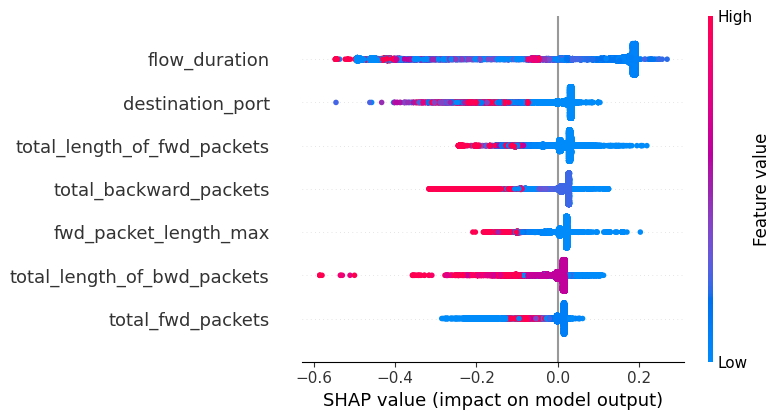

In [30]:
import shap

masker = shap.maskers.Independent(X_test)

explainer = shap.Explainer(model, masker=masker)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test,feature_names=feature_names,class_names=["normal","malicious"])

## InterpretML

In [31]:
#pip install interpret

In [35]:
import tensorflow as tf
tf.experimental.numpy.experimental_enable_numpy_behavior()

from interpret.blackbox import MorrisSensitivity
from sklearn.pipeline import Pipeline
from interpret import show

msa = MorrisSensitivity(model, X_test, feature_names=feature_names)

show(msa.explain_global())

/home/ivoafonsobispo/.local/lib/python3.10/site-packages/dash/_jupyter.py:28: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  _dash_comm = Comm(target_name="dash")


<!-- http://127.0.0.1:7049/139695294673824/ -->

## LOFO

In [33]:
#pip install lofo-importance

In [34]:
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.model_selection import KFold

target_name = "label"

column_names = feature_names + [target_name]

combined_data = np.column_stack((X_test, y_test))
combined_df = pd.DataFrame(combined_data, columns=column_names)

# define the validation scheme
cv = KFold(n_splits=4, shuffle=False, random_state=None) # Don't shuffle to keep the time split split validation

# define the binary target and the features
dataset = Dataset(df=combined_df, target="label", features=[col for col in combined_df.columns if col != "BENIGN"])

# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="roc_auc")

# get the mean and standard deviation of the importances in pandas format
importance = lofo_imp.get_importance()

importance

[LightGBM] [Info] Number of positive: 9017, number of negative: 12439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1787
[LightGBM] [Info] Number of data points in the train set: 21456, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.420255 -> initscore=-0.321725
[LightGBM] [Info] Start training from score -0.321725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

  0%|          | 0/8 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9017, number of negative: 12439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 21456, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.420255 -> initscore=-0.321725
[LightGBM] [Info] Start training from score -0.321725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3
0,total_backward_packets,NaN,NaN,0.000000,0.000000,0.000000,NaN
1,total_length_of_fwd_packets,NaN,NaN,0.000000,0.000000,0.000000,NaN
2,destination_port,NaN,NaN,0.000000,0.000000,0.000000,NaN
3,label,NaN,NaN,0.000327,0.000209,0.001524,NaN
4,flow_duration,NaN,NaN,0.000000,0.000000,0.000000,NaN
5,total_fwd_packets,NaN,NaN,0.000000,0.000000,0.000000,NaN
6,total_length_of_bwd_packets,NaN,NaN,0.000000,0.000000,0.000000,NaN
7,fwd_packet_length_max,NaN,NaN,0.000000,0.000000,0.000000,NaN
